
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#set up data for modeling
X = ha.drop(columns=["cp"])
y = ha["cp"]

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output = False), ["sex", "restecg"]),
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder = "drop"
)


In [4]:
#multiclass KNN pipeline
from sklearn.model_selection import cross_val_score
knn_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform = "pandas")

scores_knn = cross_val_score(knn_pipeline, X, y, cv = 5, scoring = "accuracy")
scores_knn

array([0.36363636, 0.41818182, 0.43636364, 0.44444444, 0.40740741])

In [5]:
# range of k values to try
param_grid = {
    "knn__n_neighbors": list(range(1,51))
}

grid_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold CV
    scoring="accuracy",   # multiclass accuracy
    n_jobs=-1             # use all cores (optional)
)

grid_knn.fit(X, y)
grid_knn.best_params_, grid_knn.best_score_


({'knn__n_neighbors': 19}, np.float64(0.5128619528619529))

In [6]:
#multiclass LDA pipeline
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis())
    ]
).set_output(transform = "pandas")


scores_lda = cross_val_score(lda_pipeline, X, y, cv = 5, scoring = "accuracy")
scores_lda

array([0.38181818, 0.43636364, 0.58181818, 0.53703704, 0.38888889])

In [7]:
#multiclass decision tree pipeline
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("dt", DecisionTreeClassifier(max_depth = 3, random_state = 42))
    ]
).set_output(transform = "pandas")

scores_dt = cross_val_score(dt_pipeline, X, y, cv = 5, scoring = "accuracy")
scores_dt

array([0.30909091, 0.50909091, 0.50909091, 0.42592593, 0.46296296])

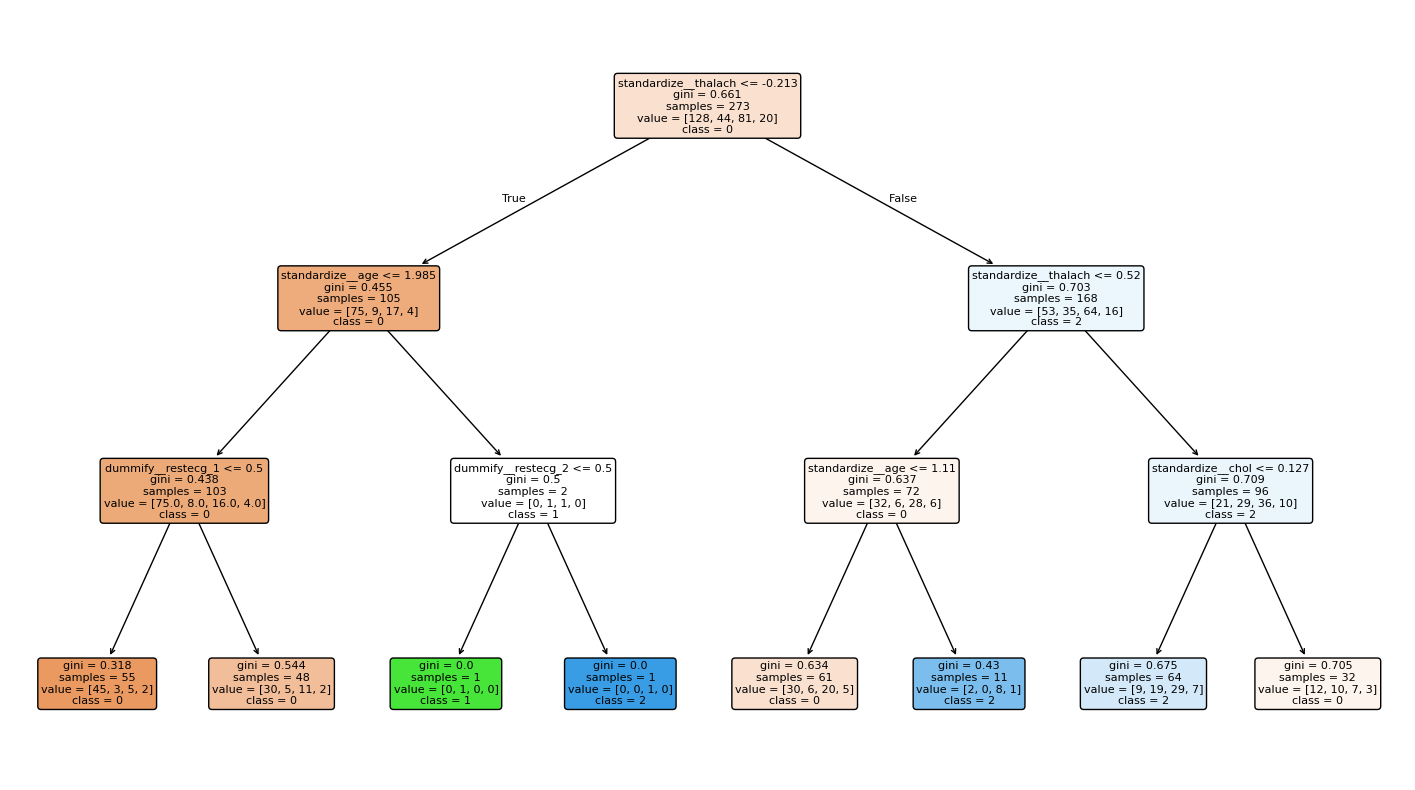

In [8]:
#plot for decision tree
dt_pipeline.fit(X, y)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

plot_tree(
    dt_pipeline["dt"],   # the tree inside your pipeline
    feature_names=dt_pipeline["preprocessing"].get_feature_names_out(),
    class_names=["0", "1", "2", "3"],
    filled=True,
    rounded=True,
    fontsize=8
)

plt.show()


Interpretation: The tree first splits on maximum heart rate, where patients with lower heart rates tend to be classified into chest-pain type 0. On the left side, age becomes the next important factor, with younger patients more likely to fall into type 0. On the right side, the model continues using heart-rate and then cholesterol and resting ECG results to separate the remaining chest-pain categories.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def run_ovr_for_category(cat):
    #create binary target column
    y_binary = (ha["cp"] == cat).astype(int)

    #logistic regression pipeline
    lr_pipeline = Pipeline(
        [
            ("preprocessing", ct),
            ("logreg", LogisticRegression(max_iter=500))
        ]
    ).set_output(transform="pandas")

    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

    #fit model
    lr_pipeline.fit(X_train, y_train)

    #predict
    preds = lr_pipeline.predict(X_test)

    #compute F1
    f1 = f1_score(y_test, preds)

    return f1

f1_scores = {}

for cat in [0, 1, 2, 3]:
    f1_scores[cat] = run_ovr_for_category(cat)

f1_scores


{0: 0.5769230769230769, 1: 0.0, 2: 0.11764705882352941, 3: 0.0}

Using a one-vs-rest logistic regression, the F1-scores for cp = 0, 1, 2, and 3 were approximately 0.58, 0, 0.12, and 0, respectively. This shows that the OvR approach was best at distinguishing chest-pain type 0, while it struggled the most with types 1 and 3, which received F1-scores of 0.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [12]:
from sklearn.metrics import roc_auc_score

def run_ovo(cat_a, cat_b):
    #only keep rows where cp is one of the two categories
    mask = ha["cp"].isin([cat_a, cat_b])
    X_sub = X[mask]
    y_sub = ha["cp"][mask]

    #recode labels to 0 and 1
    y_binary = (y_sub == cat_b).astype(int)

    #logistic regression pipeline
    lr_pipeline = Pipeline(
        [
            ("preprocessing", ct),
            ("logreg", LogisticRegression(max_iter=500))
        ]
    ).set_output(transform="pandas")

    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_binary, test_size=0.2, random_state=42
    )

    #fit model
    lr_pipeline.fit(X_train, y_train)

    # get predicted probabilities for AUC
    probs = lr_pipeline.predict_proba(X_test)[:, 1]

    # compute AUC
    auc = roc_auc_score(y_test, probs)

    return auc

auc_01 = run_ovo(0, 1)
auc_02 = run_ovo(0, 2)
auc_03 = run_ovo(0, 3)

print(auc_01, auc_02, auc_03)

0.6413043478260869 0.7806122448979592 0.8322981366459627


Overall, the 0 vs 3 pair was the easiest for the OvO approach to separate, while 0 vs 1 was the most difficult.